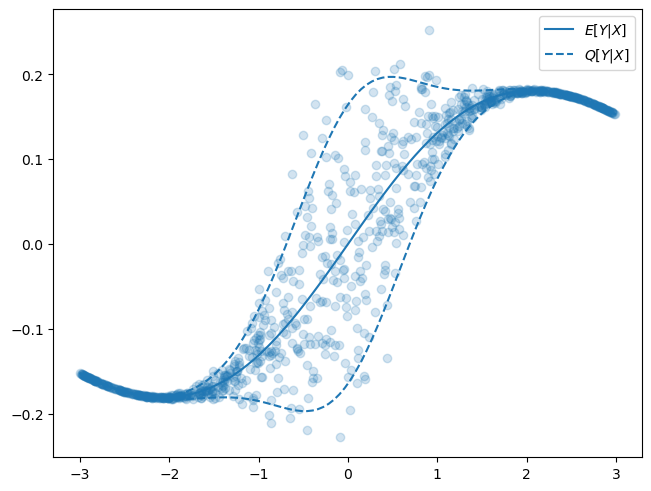

In [1]:
import numpy as np
from scipy.special import expit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

rng = np.random.default_rng(0)
n_samples = int(2e3)
x = rng.uniform(low=-3, high=3, size=n_samples)
X = x.reshape((n_samples, 1))


def true_y_mean(x):
    return expit(x) - 0.5 - 0.1 * x


def true_y_std(x):
    return 0.1 * np.exp(-(x**2) / 0.9)


y = rng.normal(loc=true_y_mean(x), scale=true_y_std(x))
X_train, X_test, x_train, x_test, y_train, y_test = train_test_split(
    X, x, y, test_size=0.5, random_state=0
)


def plot_data_generating_process(
    x,
    y,
    plot_data=True,
    max_scatter_points=1_000,
    plot_mean=True,
    plot_90p_pair=True,
    color="C0",
    highlight_indices=None,
    random_state=0,
    ax=None,
):
    x_grid = np.linspace(x.min(), x.max(), 100)
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)
    if plot_data:
        rng = np.random.default_rng(random_state)
        if x.shape[0] > max_scatter_points:
            idx = rng.choice(
                np.arange(x.shape[0]), size=max_scatter_points, replace=False
            )
            ax.scatter(x=x[idx], y=y[idx], alpha=0.2)
        else:
            ax.scatter(x=x, y=y, alpha=0.2)
            if highlight_indices:
                ax.scatter(
                    x=x[highlight_indices],
                    y=y[highlight_indices],
                    alpha=1,
                    c=np.arange(len(highlight_indices)),
                    cmap="tab10",
                    marker="^",
                )
    if plot_mean:
        ax.plot(x_grid, true_y_mean(x_grid), label="$E[Y|X]$", color=color)
    if plot_90p_pair:
        ax.plot(
            x_grid,
            true_y_mean(x_grid) + 1.645 * true_y_std(x_grid),
            linestyle="--",
            color=color,
        )
        ax.plot(
            x_grid,
            true_y_mean(x_grid) - 1.645 * true_y_std(x_grid),
            linestyle="--",
            label=r"$Q[Y|X]$",
            color=color,
        )
    ax.legend()


plot_data_generating_process(x_train, y_train)

In [2]:
# import pandas as pd

# df_train = pd.DataFrame({"x": x_train, "y": y_train})
# df_train.query("x > -1.5 & x < -1 & y < 0.1 & y > -0.18").sort_values(by="y", ascending=False)

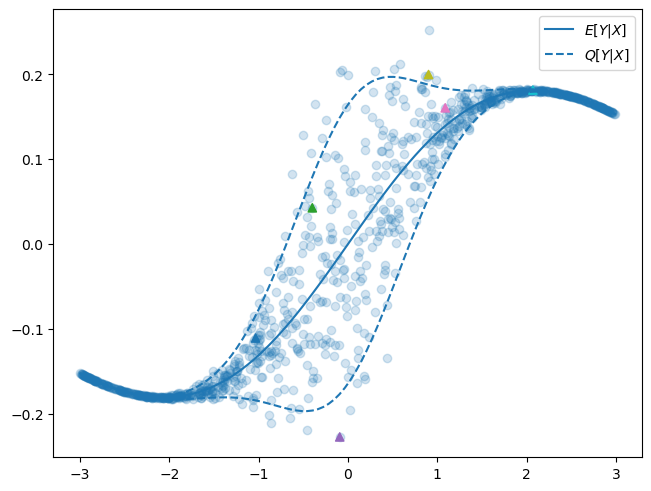

In [3]:
highlight_indices = [800, 114, 355, 619, 509, 361]
plot_data_generating_process(x_train, y_train, highlight_indices=highlight_indices)

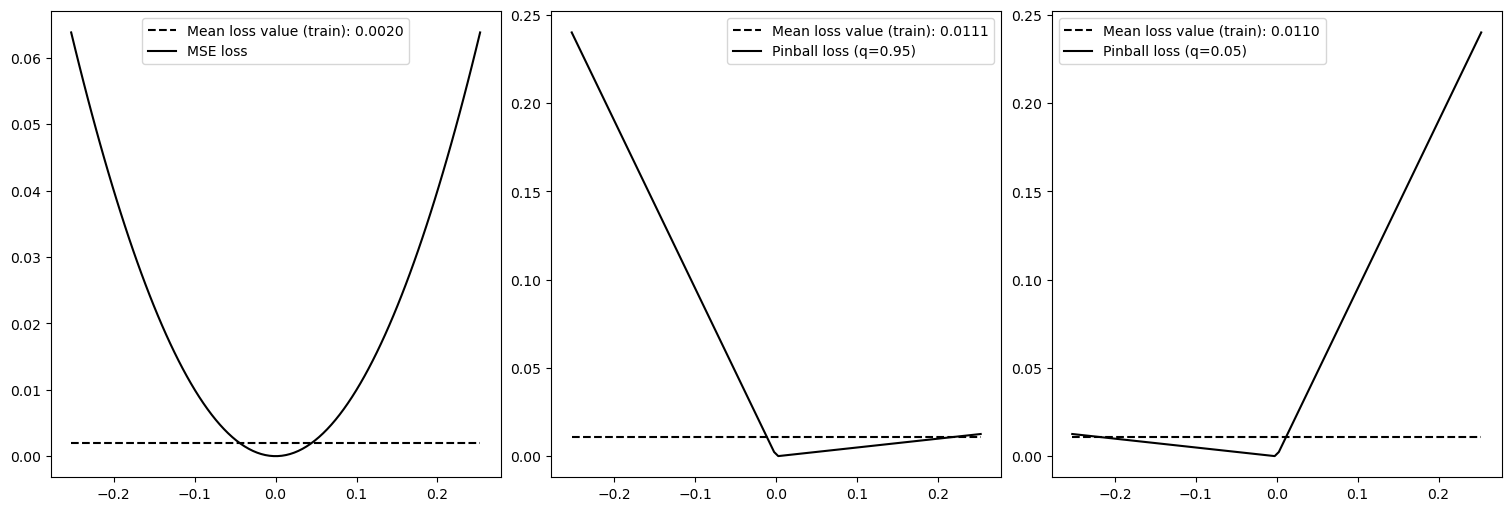

In [4]:
from sklearn.metrics import mean_squared_error, mean_pinball_loss
from functools import partial


def make_loss_function(loss_name, quantile=0.5, return_label=True):
    if loss_name == "squared_error":
        if return_label:
            return mean_squared_error, "MSE loss"
        else:
            return mean_squared_error
    elif loss_name == "quantile":
        if return_label:
            return (
                partial(mean_pinball_loss, alpha=quantile),
                f"Pinball loss (q={quantile:.2f})",
            )
        else:
            return partial(mean_pinball_loss, alpha=quantile)
    else:
        raise ValueError(f"Unsupported loss {loss_name:!r}")


def plot_loss(
    loss,
    y_true,
    y_pred,
    highlight_indices=None,
    diff_grid_range=None,
    quantile=0.6,
    data_name="train",
    mean_loss=True,
    ax=None,
):
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    loss_fun, loss_fun_label = make_loss_function(
        loss, quantile=quantile, return_label=True
    )
    if diff_grid_range is None:
        # Maximum absolute diff observed for a 0 prediction (e.g. a linear
        # model init).
        max_abs = np.abs(y_true).max()
        diff_grid_range = (-max_abs, max_abs)

    if mean_loss:
        mean_loss_value = loss_fun(y_true, y_pred)
        ax.hlines(
            mean_loss_value,
            diff_grid_range[0],
            diff_grid_range[1],
            label=f"Mean loss value ({data_name}): {mean_loss_value:.4f}",
            linestyle="--",
            color="black",
        )
    n_steps = 100
    y_pred_grid = np.linspace(diff_grid_range[0], diff_grid_range[1], n_steps)
    ax.plot(
        y_pred_grid,
        [loss_fun([0], [y_pred_grid_i]) for y_pred_grid_i in y_pred_grid],
        color="black",
        label=loss_fun_label,
    )
    ax.legend()


fig, axs = plt.subplots(ncols=3, figsize=(15, 5), constrained_layout=True)
plot_loss("squared_error", y_train, true_y_mean(x_train), ax=axs[0])
plot_loss("quantile", y_train, true_y_mean(x_train), quantile=0.05, ax=axs[2])
plot_loss("quantile", y_train, true_y_mean(x_train), quantile=0.95, ax=axs[1])


In [5]:
from sklearn.base import RegressorMixin
from sklearn.linear_model._base import LinearModel
from scipy.optimize import minimize
import warnings
from sklearn.exceptions import ConvergenceWarning


def pinball_loss_gradient(X, y, coef, intercept, quantile):
    y_pred = X @ coef + intercept
    error = y - y_pred
    mask = (error >= 0).astype(X.dtype)
    weights = -quantile * mask + (1 - quantile) * (1 - mask)
    grad_coef = weights @ X / len(y)
    grad_intercept = weights.mean()
    return grad_coef, grad_intercept


class NaiveRegressor(RegressorMixin, LinearModel):

    def __init__(
        self,
        loss="squared_error",
        quantile=0.5,
        alpha=0,
        l1_ratio=0.1,
        tol=1e-6,
        max_iter=10_000,
        verbose=False,
    ):
        self.loss = loss
        self.quantile = quantile
        self.max_iter = max_iter
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        params = np.zeros(X.shape[1] + 1)
        n_iter_holder = np.zeros(1, dtype=np.int32)

        loss_fun = make_loss_function(
            self.loss, quantile=self.quantile, return_label=False
        )

        def objective(params):
            return (
                loss_fun(y, X @ params[:-1] + params[-1])
                + self.l1_ratio * self.alpha * np.linalg.norm(params[:-1], 1)
                + (1 - self.l1_ratio) * self.alpha * np.linalg.norm(params[:-1], 2) ** 2
            )

        def iter_cb(params):
            n_iter_holder[0] += 1
            n_iter = n_iter_holder[0]
            if self.verbose and n_iter % 10 == 0:
                loss = loss_fun(y, X @ params[:-1] + params[-1])
                print(f"{self.loss} at iteration {n_iter}: {loss:.6f}")
            if n_iter_holder[0] >= self.max_iter:
                warnings.warn(
                    f"Fail to converge after reaching {self.max_iter} iterations",
                    ConvergenceWarning,
                )
                raise StopIteration()

        result = minimize(objective, params, tol=self.tol, callback=iter_cb)
        params = result.x
        self.coef_ = params[:-1]
        self.intercept_ = params[-1]
        self.n_iter_ = n_iter_holder[0]
        return self

    def predict(self, X):
        return X @ self.coef_ + self.intercept_

In [6]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

n_knots = 7
shared_params = dict(
    tol=1e-4,
    max_iter=1000,
    alpha=1e-6,
    l1_ratio=0.1,
)
poly_reg_triplet = (
    make_pipeline(SplineTransformer(n_knots=n_knots), NaiveRegressor(**shared_params)).fit(
        X_train, y_train
    ),
    make_pipeline(
        SplineTransformer(n_knots=n_knots),
        NaiveRegressor(loss="quantile", quantile=0.05, **shared_params),
    ).fit(X_train, y_train),
    make_pipeline(
        SplineTransformer(n_knots=n_knots),
        NaiveRegressor(loss="quantile", quantile=0.95, **shared_params),
    ).fit(X_train, y_train),
)
tuple(int(getattr(e.steps[-1][1], "n_iter_", 1)) for e in poly_reg_triplet)

(23, 65, 108)

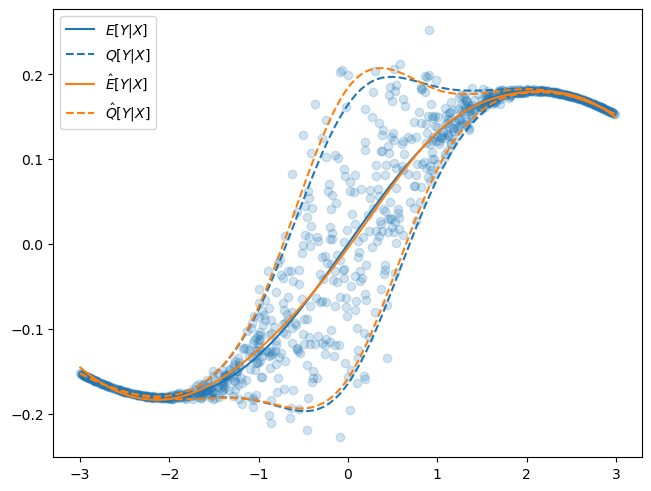

In [7]:
def plot_model_triplet(models, x, y, ax=None, color="C1"):
    x_grid = np.linspace(x.min(), x.max(), 100)
    X_grid = x_grid.reshape((x_grid.shape[0], 1))
    if ax is None:
        _, ax = plt.subplots(constrained_layout=True)

    ax.plot(x_grid, models[0].predict(X_grid), label=r"$\hat{E}[Y|X]$", color=color)
    ax.plot(
        x_grid,
        models[1].predict(X_grid),
        linestyle="--",
        color=color,
    )
    ax.plot(
        x_grid,
        models[2].predict(X_grid),
        linestyle="--",
        label=r"$\hat{Q}[Y|X]$",
        color=color,
    )
    ax.legend()


fig, ax = plt.subplots(constrained_layout=True)
plot_data_generating_process(x_train, y_train, ax=ax)
plot_model_triplet(poly_reg_triplet, x_train, y_train, ax=ax)